In [1]:
from ioi_utils import Node, get_model
from mandala._next.imports import *
from mandala._next.common_imports import *
from greater_than_utils import *
from tqdm import tqdm

MODEL_ID = 'gpt2-small'
if 'model' in locals():
    MODELS[MODEL_ID] = model

# A proof-of-concept evaluation for the greater-than circuit

In [2]:
DB_PATH = '/media/amakelov/SanDisk1TB/paper_sprint/greater_than.db'
storage = Storage(db_path=DB_PATH)

In [3]:
model = get_model()
MODELS[MODEL_ID] = model

/home/amakelov/workspace/current/conda_envs/serimats/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer


# Prepare data

In [4]:
with storage:
    P_train = generate_prompts(n_prompts=10_000, distribution=FULL_DISTRIBUTION, random_seed=0)
    As_train = run_with_cache(
        prompts=P_train,
        nodes=NODES,
        batch_size=200,
    )
    A_TRAIN_DICT = {node: A for node, A in zip(NODES, As_train)}

    N_YYS = len(YYS)
    editing_base_distribution = copy.deepcopy(FULL_DISTRIBUTION)
    editing_base_distribution.yys = editing_base_distribution.yys[:N_YYS // 2]
    editing_source_distribution = copy.deepcopy(FULL_DISTRIBUTION)
    editing_source_distribution.names = editing_source_distribution.yys[N_YYS // 2:]

    P_eval = generate_prompts(n_prompts=5_000, distribution=editing_base_distribution, random_seed=1)
    As_eval = run_with_cache(
        prompts=P_eval, 
        nodes=NODES,
        batch_size=200,
    )
    A_EVAL_DICT = {node: A for node, A in zip(NODES, As_eval)}
    P_eval_feature_idxs = get_prompt_feature_idxs(
        prompts=P_eval,
        features=[('yy',)],
    )

    N_EVAL = len(storage.unwrap(P_eval))
    N_YYS_EVAL_SOURCE = len(editing_source_distribution.yys)

    ############################################################################ 
    ### Compute counterfactual prompts and activations
    ############################################################################ 
    ATTRIBUTES = [('yy',), ] # ('s', 'io_pos',), ('io', 'io_pos'), ('s', 'io',), ('io_pos', 's', 'io',), ]

    CF_PROMPTS_DICT = {}
    for attribute in ATTRIBUTES:
        CF_PROMPTS_DICT[attribute] = get_cf_prompts(
            prompts=P_eval, 
            features=attribute,
            yy_targets=generate_yy_samples(n_samples=N_EVAL, yys=editing_source_distribution.yys),
        )
    ### Compute counterfactual activations
    A_EVAL_CF_DICT = {}
    for attribute, cf_prompts in tqdm(CF_PROMPTS_DICT.items()):
        A_EVAL_CF_DICT[attribute] = run_with_cache(
            prompts=cf_prompts, 
            nodes=NODES,
            batch_size=100,
            model_id=MODEL_ID,
            verbose=True,
        )
    for attribute in A_EVAL_CF_DICT:
        A_EVAL_CF_DICT[attribute] = {node: A_EVAL_CF_DICT[attribute][i] for i, node in enumerate(NODES)}
    
    P_eval_cf_feature_idxs = {}
    for attribute, cf_prompts in CF_PROMPTS_DICT.items():
        P_eval_cf_feature_idxs[attribute] = get_prompt_feature_idxs(
            prompts=cf_prompts,
            features=[attribute],
        )

100%|██████████| 1/1 [00:00<00:00, 58.66it/s]


# Compute supervised features

In [ ]:
FEATURE_CONFIGURATIONS

In [ ]:
with storage:
    SUPERVISED_FEATURES_DICT = {}
    SUPERVISED_RECONSTRUCTIONS_DICT = {}
    for node, A in tqdm(A_TRAIN_DICT.items()):
        node_parametrization = 'independent'
        node_features = FEATURE_CONFIGURATIONS[node_parametrization]
        code_getter = get_mean_codes
        codes, reconstructions = code_getter(
            features=node_features,
            A=A,
            prompts=P_train,
        )
        SUPERVISED_FEATURES_DICT[node] = codes
        SUPERVISED_RECONSTRUCTIONS_DICT[node] = reconstructions

# Train vanilla SAEs

In [5]:
### define a uniform schedule for all training runs

# use exponentially spread-out checkpoints for the very early stages of training
# measure right before resampling, as well as in the middle between resamplings
# measure before and after the final LR decay
# use two resampling stages, as it seems effects diminish after the first one
CHECKPOINT_STEPS = [0, 1, 2, 4, 8, 16, 32, 64, 128, 500, 750, 1000, 1250, 1500, 2000]
RESAMPLE_EPOCHS = [501, 1001, ]
FINAL_DECAY_START = 1500 # decay the LR for the last 25% of training
FINAL_DECAY_END = 2000

In [6]:
SAES_DICT = {} # (variant, node, l1, start_epoch) -> encoder
EDITED_INTERP_DICT = {} # (variant, node, l1, end_epoch, attribute, num_exchange) -> A_edited
EDITED_AGNOSTIC_DICT = {} # (variant, node, l1, end_epoch, attribute, num_exchange) -> A_edited

# collecting the weight removed
WEIGHT_REMOVED_DICT = {} # (variant, node, l1, end_epoch, attribute, num_exchange, edit_type, ) -> weight_removed

In [7]:
from torch.optim import Adam

collect_metrics = False

with storage:
    metrics_dfs = []
    for node in tqdm(NODES):
        A_train = A_TRAIN_DICT[node]
        A_train_normalized, scale = normalize_activations(A=A_train)

        A_eval = A_EVAL_DICT[node]
        A_eval_normalized, _ = normalize_activations(A=A_eval, scale=scale)

        for l1_coeff in (1.0, DefaultConfig.L1_COEFF):
            for lr in (DefaultConfig.LR, ):
                for batch_size in (512, ):
                    for dict_mult in (8, ):
                        encoder_state_dict = None
                        optimizer_state_dict = None
                        scheduler_state_dict = None
                        metrics_list = []
                        d_hidden = dict_mult * 64
                        pbar = tqdm(list(zip(CHECKPOINT_STEPS, CHECKPOINT_STEPS[1:])), disable=True)
                        for start_epoch, end_epoch in pbar:
                            encoder_state_dict, optimizer_state_dict, scheduler_state_dict, metrics = train_vanilla(
                                A=A_train_normalized,
                                start_epoch=start_epoch,
                                d_hidden=d_hidden,
                                end_epoch=end_epoch,
                                batch_size=batch_size,
                                encoder_state_dict=encoder_state_dict,
                                optimizer_state_dict=optimizer_state_dict,
                                scheduler_state_dict=scheduler_state_dict,
                                l1_coeff=l1_coeff,
                                lr=lr,
                                resample_epochs=RESAMPLE_EPOCHS,
                                final_decay_start=FINAL_DECAY_START,
                                final_decay_end=FINAL_DECAY_END,
                            )
                            if collect_metrics: 
                                metrics = storage.unwrap(metrics)

                            ### compute the logitdiff recovered metric
                            encoder = get_vanilla(d_activation=64, d_hidden=d_hidden, encoder_state_dict=encoder_state_dict)
                            if collect_metrics:
                                metrics_list.append(metrics)


                            SAES_DICT[('vanilla', node, l1_coeff, end_epoch)] = encoder
                            ### compute high F1-score features
                            top_f1_features, top_f1_scores = get_high_f1_features(
                                encoder=encoder,
                                attributes=[('yy',),],
                                A_normalized=A_eval_normalized,
                                prompt_feature_idxs=P_eval_feature_idxs,
                                topk=d_hidden,
                            )

                            ### interp-agnostic edits
                            for attribute in [('yy',), ]:
                                for num_exchange in (2, 4, 8, 16):
                                    A_eval_cf = A_EVAL_CF_DICT[attribute][node]
                                    A_eval_cf_normalized, _ = normalize_activations(A=A_eval_cf, scale=scale)
                                    A_edited, best_features, best_scores, edited_clean, edited_cf = get_edit_using_sae_opt(
                                        A_clean_normalized=A_eval_normalized,
                                        A_cf_normalized=A_eval_cf_normalized,
                                        encoder=encoder,
                                        num_exchange=num_exchange,
                                        batch_size=200,
                                        normalization_scale=scale,
                                    )
                                    EDITED_AGNOSTIC_DICT[('vanilla', node, l1_coeff, end_epoch, attribute, num_exchange)] = A_edited

                        if collect_metrics:
                            all_metrics = [elt for x in metrics_list for elt in x]
                            metrics_df = pd.DataFrame(all_metrics)
                            metrics_df['l1_coeff'] = l1_coeff
                            metrics_df['lr'] = lr
                            metrics_df['dict_mult'] = dict_mult
                            metrics_df['node'] = node.displayname
                            metrics_df['batch_size'] = batch_size
                            metrics_dfs.append(metrics_df)
        storage.commit()
        storage.atoms.clear()

    if collect_metrics:
        metrics_df_vanilla = pd.concat(metrics_dfs)


100%|██████████| 7/7 [00:16<00:00,  2.38s/it]


In [8]:
rows = []
for i, ((variant, node, l1_coeff, end_epoch, attribute, num_exchange), A_edited) in tqdm(enumerate(EDITED_AGNOSTIC_DICT.items())):
    x = storage.load_ref(hid=A_edited.hid, lazy=False).obj
    dist_l2 = get_activation_distance.f(
        A_target=storage.unwrap(A_EVAL_CF_DICT[attribute][node]),
        A_edited=x,
        A_target_grad=None,
        method='l2',
    )
    rows.append({
        'variant': variant,
        'edit_type': 'agnostic',
        'node': node,
        'l1_coeff': l1_coeff,
        'end_epoch': end_epoch,
        'attribute': attribute,
        'num_exchange': num_exchange,
        'dist_method': 'l2',
        'dist': dist_l2.item(),
    })
    if i % 1_000 == 0:
        storage.atoms.clear()

EDIT_SELECTION_DF = pd.DataFrame(rows)
EDIT_SELECTION_DF['node'] = EDIT_SELECTION_DF['node'].map(lambda x: x.displayname)

784it [00:06, 122.66it/s]


In [9]:
### collect the encoder with the best distance for each variant, node, attribute, num_exchange, dist_method by minimizing over l1_coeff and end_epoch
x = EDIT_SELECTION_DF.groupby(['variant', 'edit_type', 'node', 'attribute', 'num_exchange', 'dist_method'])['dist'].idxmin()
# x = EDIT_SELECTION_DF.groupby(['variant', 'edit_type', 'node', 'attribute', 'num_exchange', 'dist_method'])['dist'].min().reset_index()
# now, choose the values of l1_coeff and end_epoch that minimize the distance
EDIT_SELECTION_DF_BEST = EDIT_SELECTION_DF.loc[x]

In [ ]:
EDIT_SELECTION_DF_BEST

In [10]:
SELECTED_SAES = {} # (variant, edit_type, node, attribute, num_exchange, dist_method) -> encoder
node_to_displayname = {node: node.displayname for node in NODES}
displayname_to_node = {v: k for k, v in node_to_displayname.items()}
for (variant, edit_type, node_name, l1_coeff, end_epoch, attribute, num_exchange, dist_method, _) in tqdm(EDIT_SELECTION_DF_BEST.itertuples(index=False)):
    node = displayname_to_node[node_name]
    SELECTED_SAES[(variant, edit_type, node, attribute, num_exchange, dist_method)] = (SAES_DICT[(variant, node, l1_coeff, end_epoch)], l1_coeff, end_epoch)

28it [00:00, 120575.47it/s]
28it [00:00, 120575.47it/s]


In [11]:
EDITED_DICT = {}
for k, v in EDITED_AGNOSTIC_DICT.items():
    EDITED_DICT[k + ('agnostic',)] = v

In [15]:
### the actual interventions
paper_cross_sections = [
    # yy
    (NODES, ('yy',), 'nm+bnm@z'),
]

locations_to_edit = paper_cross_sections

def get_lds(logits: Tensor) -> np.ndarray:
    return (storage.unwrap(logits)[:, 0] - storage.unwrap(logits)[:, 1]).cpu().numpy()

def stringify_nodes(nodes: List[Node]) -> str:
    return ', '.join([node.displayname for node in nodes])

dfs = []
NUM_EXCHANGE_VALUES = [0, 2, 4, 8, 16]

with storage:
    for nodes_to_edit, feature_subset_to_edit, heads_class in tqdm(locations_to_edit):
        cf_activations = {node: A_EVAL_CF_DICT[feature_subset_to_edit][node] for node in nodes_to_edit}
        cf_prompts = CF_PROMPTS_DICT[feature_subset_to_edit]
        nodes_order = sorted(nodes_to_edit, key=lambda node: node.displayname)
        
        # correct_predictions_base = model.to_tokens([f' {p.io_name}' for p in storage.unwrap(P_eval)])[:, 1]
        # correct_predictions_cf = model.to_tokens([f' {p.io_name}' for p in storage.unwrap(cf_prompts)])[:, 1]

        for num_exchange in NUM_EXCHANGE_VALUES:
            for edit_type in ('agnostic', ):
                for variant in ('vanilla',):
                    for dist_method in ('l2',):
                        if num_exchange != 0:
                            best_encoder_data = {node: SELECTED_SAES[(variant, edit_type, node, feature_subset_to_edit, num_exchange, dist_method)] for node in nodes_to_edit}
                            best_edited_activations = {node: EDITED_DICT[(variant, node, l1_coeff, end_epoch, feature_subset_to_edit, num_exchange, edit_type)]
                                                for node, (encoder, l1_coeff, end_epoch) in best_encoder_data.items()}
                        else:
                            best_edited_activations = {node: A_EVAL_DICT[node] for node in nodes_to_edit}
                        ### intervention outcome
                        base_logits_edit, thing = run_activation_patch(
                            base_prompts=P_eval,
                            cf_prompts=cf_prompts,
                            batch_size=50,
                            nodes=nodes_order,
                            activations=[best_edited_activations[node] for node in nodes_order],
                            return_predictions=True,
                        )
                        cf_logits_edit, predictions_edit = storage.unwrap(thing)
                        # accuracy_edit_base = (predictions_edit == correct_predictions_base).float().mean().item()
                        # accuracy_edit_cf = (predictions_edit == correct_predictions_cf).float().mean().item()
                        # base_logits_edit, cf_logits_edit = storage.unwrap(base_logits_edit), storage.unwrap(cf_logits_edit)

                        ### baseline (counterfactual patching) outcome
                        base_logits_patch, thing = run_activation_patch(
                            base_prompts=P_eval,
                            cf_prompts=cf_prompts,
                            batch_size=50,
                            nodes=nodes_order,
                            activations=[cf_activations[node] for node in nodes_order],
                            return_predictions=True,
                        )
                        cf_logits_patch, predictions_patch = storage.unwrap(thing)
                        # accuracy_patch_base = (predictions_patch == correct_predictions_base).float().mean().item()
                        # accuracy_patch_cf = (predictions_patch == correct_predictions_cf).float().mean().item()

                        # base_logits_patch, cf_logits_patch = storage.unwrap(base_logits_patch), storage.unwrap(cf_logits_patch)
                        # base_lds_edit = get_lds(base_logits_edit)
                        # cf_lds_edit = get_lds(cf_logits_edit)
                        # base_lds_patch = get_lds(base_logits_patch)
                        # cf_lds_patch = get_lds(cf_logits_patch)

                        df = pd.DataFrame({
                            # params
                            'num_exchange': num_exchange,
                            'nodes_to_edit': stringify_nodes(nodes_to_edit),
                            'heads_class': heads_class,
                            'attribute': [feature_subset_to_edit[0] for _ in range(len(storage.unwrap(predictions_edit)))],
                            'edit_type': edit_type,
                            'prompt_idx': list(range(len(storage.unwrap(predictions_edit)))),
                            'variant': variant,
                            'dist_method': dist_method,
                            # agreement between cf predictions and edit predictions
                            'agreement_with_cf': (predictions_edit == predictions_patch).cpu().numpy(),
                            # 'removed_weight': torch.cat(removed_weights).cpu().numpy(),
                            # 'baseline_removed_weight': torch.cat(baseline_removed_weights).cpu().numpy(),
                            # weight removed
                            # 'weight_removed_fraction': np.mean(removed_weights),
                        })
                        dfs.append(df)
                        storage.commit()
                        storage.atoms.clear()
                        torch.cuda.empty_cache()
df = pd.concat(dfs)

100%|██████████| 1/1 [00:14<00:00, 14.85s/it]


In [26]:
x = df.groupby(['num_exchange',])['agreement_with_cf'].mean().reset_index()

Text(0, 0.5, 'Edit accuracy')

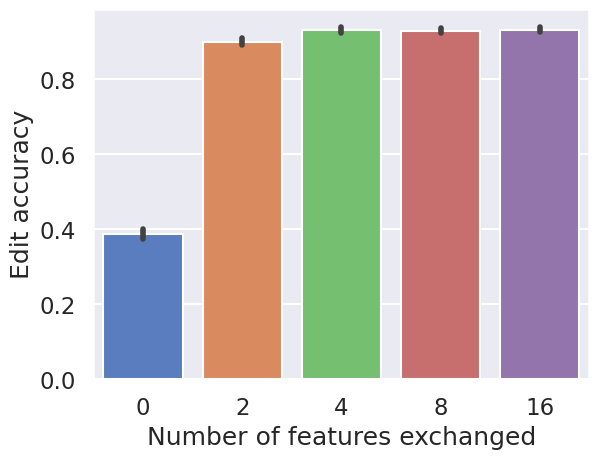

In [29]:
alt.Chart(x).mark_bar().encode(
    x='num_exchange:O',
    y='agreement_with_cf',
)

# same plot in seaborn
fig, ax = plt.subplots()
sns.barplot(x='num_exchange', y='agreement_with_cf', data=df, ax=ax)
# rename the x and y axes
ax.set_xlabel('Number of features exchanged')
ax.set_ylabel('Edit accuracy')